# Perform a looping with a quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [2]:
import quadrotor
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.45
Length  = 0.14
Inertia = 0.09
Dt      = 0.04
state size   = 6
control size = 2




## Part 1 - Setting up the trajectory optimization problem (50 points)
1. Discretize the system dynamics using Euler's method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping (i.e. a back or front flip). Find and implement a suitable cost function to perform a looping and add constraints to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP with a long horizon to ensure that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Plot the value of $\alpha$ (during line search) at each iteration of the solver as well as the amount of constraint violation per iteration and the cost per iteration of the solver (also useful to help you debug).
5. Describe your design choices (in a concise manner) in the report.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function and show the animation (show the plots in your report).

### Tips to implement a SQP solver
1. Write down the algorithm (in words not in code), i.e. write all the steps you need to take
2. Write the gradient of the running cost at a given guess $\bar{x} = [{\bar{p}_x}_0, {\bar{v}_x}_0, {\bar{p}_y}_0, {\bar{v}_{y}}_0, \bar{\theta}_0, \bar{\omega}_0, {\bar{u}_1}_0, {\bar{u}_2}_0, \dots, {\bar{p}_x}_N, {\bar{v}_x}_N, {\bar{p}_y}_N, {\bar{v}_{y}}_N, \bar{\theta}_N, \bar{\omega}_N, {\bar{u}_1}_N, {\bar{u}_2}_N,]^T$, i.e. for a given value of these variables and implement a function that computes it
3. Write the Hessian of the running cost at a given guess $\bar{x}$ and implement a function that computes it
4. Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
5. Write a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
6. Use these functions to setup the inner QP of the SQP (use the library from HW2 to solve the QP).
7. Implement a function that computes the amount of constraint violation for the nonlinear constraints (not the linearized one), i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
8. Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
9. Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions are satisfied (within a small margin, e.g. $10^{-4}$).

Once you have a solution, make sure to check that it satisfies the constraints! You can display the robot using the ```animate_robot``` function.

#### (Simple) filter linear search
Once you have a potential step $\textrm{step}_x$, you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha \textrm{step}_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha \textrm{step}_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha \textrm{step}_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha \textrm{step}_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha \textrm{step}_x$

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below (you may need to use a shorter horizon). In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

# Part 1: Trajectory Optimization Problem

To minimize cost function,
$$
J(x(t), u(t), t_0, t_f) = S(x(t_f), t_f) + \int_{t_0}^{t_f}L(x(t), u(t), t)dt
$$

where we define Terminal Cost as,
$$
S(x(t_f), t_f) = \frac{1}{2}(x(t_f) - x_{ref}(t_f))^T P (x(t_f) - x_{ref}(t_f))
$$

and Running cost as,
$$
L(x(t), u(t), t) = \frac{1}{2}(x(t) - x_{ref}(t))^T Q (x(t) - x_{ref}(t)) + \frac{1}{2}u(t)^T R u(t)
$$

Subject to constraints,
$$
\begin{align*}
u_{min} < u < u_{max} \text{ for } u_{min} = 0, u_{max} = 10 \\
\end{align*}
$$

for tuning matrices $P$, $Q$, and $R$, to incentivize the system to follow a reference trajctory $x_{ref}$.

The system dynamics is defined by,
$$
\dot{x} = f(x(t), u(t), t)dt
$$

$$\begin{align*} 
& \dot{p_x} = v_x\\
& m \dot{v}_x = - (u_1 + u_2) \sin \theta \\ 
& \dot{p_y} = v_y\\
& m \dot{v}_y = (u_1 + u_2) \cos \theta  - m g\\
& \dot{\theta} = \omega\\
& I \dot{\omega} = r (u_1 - u_2) 
\end{align*}$$

for the state vector,
$$
x =
\begin{pmatrix}
p_x \\
v_x \\
p_y \\
v_y \\
\theta\\
\omega\\
\end{pmatrix}
$$

## 1. Discrete Time Formulation

For Euler discretization $x_{t+1} = x_{t} + \Delta t f(x_t, u_t)$,
$$
f(x_t, u_t) = 
\begin{pmatrix}
v_{x,t} \\
-\frac{u_{1,t}+u_{2,t}}{m} \sin \theta_t \\
v_{y,t} \\
\frac{u_{1,t}+u_{2,t}}{m} \cos \theta_t - g \\
\omega_t\\
r\frac{u_{1,t} - u_{2,t}}{I}\\
\end{pmatrix}
$$

Discrete cost function,
$$
\begin{align*}
& J(x_t, x_T, u_t, t, T) = S(x_T, T) + \sum_{t=0}^{T - 1} L(x_t, u_t, t) \\
\text{for } & S(x_T, T) = \frac{1}{2}(x_T - x_{ref, T})^T P (x_T - x_{ref, T}) \\
\text{and } & L(x_t, u_t, t) = \frac{1}{2}(x_t - x_{ref,t})^T Q (x_t - x_{ref,t}) + \frac{1}{2}u_t^T R u_t \\
\text{subject to } & u_{min} < u_t < u_{max} \text{ for } u_{min} = 0, u_{max} = 10
\end{align*}
$$

## 2. Gradient and Hessian of the cost function

for a given state $\bar{x}$, 
$$
\begin{align*}
& L(\bar{x}, \bar{u}) = \frac{1}{2}(\bar{x} - \bar{x}_{ref})^T Q (\bar{x} - \bar{x}_{ref}) + \frac{1}{2}\bar{u}^T R \bar{u} \\
\end{align*}
$$

Thus, the gradient,
$$
\begin{align*}
& \nabla_ {\bar{x}} J = Q (\bar{x} - \bar{x}_{ref}) \\
& \nabla_ {\bar{u}} J = R \bar{u}
\end{align*}
$$

and the hessian,
$$
\nabla^2_ {\bar{x}\bar{x}} J = Q
$$
Or $P$ for the terminal cost.

<!-- ## 3. Linearization of System Dynamics
For non-linear dynamics,
$$
x_{t+1} =
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
x_{t}
+
\begin{bmatrix}
0 & 0 \\
\frac{- \sin \theta}{m} & \frac{- \sin \theta}{m} \\
0 & 0 \\
\frac{\cos \theta}{m} & \frac{\cos \theta}{m} \\
0 & 0 \\
\frac{r}{I} & -\frac{r}{I} \\
\end{bmatrix}
u_{t}
+
\begin{bmatrix}
0 \\
0 \\
0 \\
-g \\
0 \\
0 \\ 
\end{bmatrix}
$$-->

In [34]:
import numpy as np
from qpsolvers import solve_qp
from scipy.sparse import csr_matrix

class SQP_solver:
    def __init__(self, quadrotor, T, x_0, 
                 P = None, Q = None, R = None, u_min=0.0, u_max=10.0, 
                 rho = 0.5, max_iter = 1024, min_iter = 16, tol = 1e-6):
        
        # Model Properties
        self.nx = quadrotor.DIM_STATE
        self.nu = quadrotor.DIM_CONTROL
        self.dt = quadrotor.DT
        self.m = quadrotor.MASS
        self.I = quadrotor.INERTIA
        self.r = quadrotor.LENGTH
        self.g = quadrotor.GRAVITY_CONSTANT

        # Number of time steps
        self.T = T

        # Weight Matrices // [px, vx, py, vy, theta, omega] // [u1, u2] // np.diag([1.0, 1.0])
        self.P = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) if P is None else P
        self.Q = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) if Q is None else Q
        self.R = np.eye(self.nu) if R is None else R
        self.u_min, self.u_max = u_min, u_max

        # Line search parameter
        self.rho = rho
        
        # General parameters
        self.max_iter = max_iter
        self.min_iter = min_iter
        self.tol = tol

        # QP variables
        self.x_0 = x_0.copy()
        self.nz = (T+1)*self.nx + T*self.nu
        self.f_best = np.inf
        self.c_best = np.inf

        # History
        self.history = [{
            "iter": "t",
            "cost": "J",
            "violation": "||c||_1",
            "alpha": "alpha"
        }]               
            
    # Utility Functions
    def unpack(self, z):
        X = np.zeros((self.T + 1, self.nx))
        U = np.zeros((self.T, self.nu))

        for t in range(self.T):
            idx_x = t * (self.nx + self.nu)
            idx_u = t * (self.nx + self.nu) + self.nx

            X[t] = z[idx_x: idx_x + self.nx]
            U[t] = z[idx_u: idx_u + self.nu]
        idx_terminal = self.T * (self.nx + self.nu)
        X[self.T] = z[idx_terminal: idx_terminal + self.nx]
        return X, U 
    
    def pack(self, X, U):
        z = np.zeros(self.nz)

        for t in range(self.T):
            idx_x = t * (self.nx + self.nu)
            idx_u = t * (self.nx + self.nu) + self.nx
            
            z[idx_x: idx_x + self.nx] = X[t]
            z[idx_u: idx_u + self.nu] = U[t]
        idx_terminal = self.T * (self.nx + self.nu)
        z[idx_terminal: idx_terminal + self.nx] = X[self.T]
        return z
    
    # Dynamics
    def next_state(self, x, u):
        _, v_x, _, v_y, theta, omega = x
        u_1, u_2 = u

        return np.array([
            v_x,
            -(u_1 + u_2)/self.m * np.sin(theta),
            v_y,
            (u_1 + u_2)/self.m * np.cos(theta) - self.g,
            omega,
            self.r/self.I * (u_1 - u_2)
        ])
    
    def grad_x(self, x, u):
        _, _, _, _, theta, omega = x
        u_1, u_2 = u

        Jacobian = np.zeros((self.nx, self.nx))
        Jacobian[0,1] = 1
        Jacobian[2,3] = 1
        Jacobian[4,5] = 1
        Jacobian[1,4] = -(u_1+u_2)/self.m * np.cos(theta)
        Jacobian[3,4] = -(u_1+u_2)/self.m * np.sin(theta)
        return Jacobian
    
    def grad_u(self, x, u):
        _, _, _, _, theta, omega = x
        u_1, u_2 = u

        Jacobian = np.zeros((self.nx, self.nu))
        Jacobian[1,0] = -(1.0/self.m) * np.sin(theta)
        Jacobian[1,1] = -(1.0/self.m) * np.sin(theta)
        Jacobian[3,0] =  (1.0/self.m) * np.cos(theta)
        Jacobian[3,1] =  (1.0/self.m) * np.cos(theta)
        Jacobian[5,0] =  self.r/self.I
        Jacobian[5,1] = -self.r/self.I
        return Jacobian

    # QP functions
    def cost_function(self, z, X_ref):
        X, U = self.unpack(z)
        J = 0.0
        for t in range(self.T):
            error_X = X[t] - X_ref[t]
            J += 0.5 * error_X @ self.Q @ error_X + 0.5 * U[t] @ self.R @ U[t]
        error_terminal = X[self.T] - X_ref[self.T]
        J += 0.5 * error_terminal @ self.P @ error_terminal
        return J

    def get_gradients(self, z, X_ref):
        hessian = np.zeros((self.nz, self.nz))
        gradient = np.zeros(self.nz)

        X, U = self.unpack(z)

        for t in range(self.T):
            idx_x = t * (self.nx + self.nu)
            idx_u = t * (self.nx + self.nu) + self.nx 

            error_X = X[t] - X_ref[t]
            gradient[idx_x: idx_x + self.nx] = self.Q @ error_X
            gradient[idx_u: idx_u + self.nu] = self.R @ U[t]
            hessian[idx_x: idx_x + self.nx, idx_x: idx_x + self.nx] = self.Q
            hessian[idx_u: idx_u + self.nu, idx_u: idx_u + self.nu] = self.R
        idx_terminal = self.T * (self.nx + self.nu)
        error_terminal = X[self.T] - X_ref[self.T]
        gradient[idx_terminal: idx_terminal + self.nx] = self.P @ error_terminal
        hessian[idx_terminal: idx_terminal + self.nx, idx_terminal: idx_terminal + self.nx] = self.P
        
        return gradient, hessian

    def get_defect(self, x, u, x_next):
        return x_next - x - self.dt * self.next_state(x, u)

    def get_constraints(self, z):
        X, U = self.unpack(z)   
        ncon = (self.T + 1) * self.nx

        # Dynamics Constraints
        G = np.zeros((ncon, self.nz))
        b = np.zeros(ncon)
        
        # Equality Constraint at x0
        row = 0
        for i in range(self.nx):
            G[row, i] = 1.0  
            b[row] = -self.x_0[i]
            row += 1

        for t in range(self.T):
            x, u, x_next = X[t], U[t], X[t+1]
            c = self.get_defect(x, u, x_next)

            A = self.grad_x(x, u)
            B = self.grad_u(x, u)

            G_x = -(np.eye(self.nx) + self.dt * A)
            G_u = -self.dt * B
            G_xn = np.eye(self.nx)

            idx_x = t * (self.nx + self.nu)
            idx_u = t * (self.nx + self.nu) + self.nx 
            idx_xn = (t + 1) * (self.nx + self.nu)

            G[row:row + self.nx, idx_x: idx_x + self.nx] = G_x
            G[row:row + self.nx, idx_u: idx_u+self.nu] = G_u
            G[row:row + self.nx, idx_xn: idx_xn+self.nx] = G_xn
            b[row:row + self.nx] = -c
            row += self.nx  

        # Inequality Constraints
        nineq = 2 * self.T * self.nu + (self.T + 1)

        M = np.zeros((nineq, self.nz))
        p = np.zeros(nineq)

        ineq_row = 0
        for t in range(self.T):
            idx_ut = t * (self.nx + self.nu) + self.nx 
        
            # Upper bound:
            for i in range(self.nu):
                M[ineq_row, idx_ut + i] = 1.0
                p[ineq_row] = self.u_max
                ineq_row += 1
            
            # Lower bound:
            for i in range(self.nu):
                M[ineq_row, idx_ut + i] = -1.0
                p[ineq_row] = - self.u_min
                ineq_row += 1

        # Altitude constraints:
        for t in range(self.T + 1):
            idx_c = t * (self.nx + self.nu)
            M[ineq_row, idx_c + 2] = -1.0
            p[ineq_row] = 0.0
            ineq_row += 1
            
        return G, b, M, p
    
    def solve_QP(self, hessian, gradient, G, b, M, p):
        hessian_sparse = csr_matrix(hessian)
        G_sparse = csr_matrix(G)
        M_sparse = csr_matrix(M)
        

        z_sol = solve_qp(
            hessian_sparse,
            gradient,
            M_sparse,
            p,
            G_sparse,
            b,
            solver = 'osqp' 
        )
        return z_sol 

    # Line search functions
    def violation(self, z):
        X, U = self.unpack(z)
        value = 0.0
        for t in range(self.T):
            x, u, x_next = X[t], U[t], X[t+1]
            c = self.get_defect(x, u, x_next)

            value += np.sum(np.abs(c))
            value += np.sum(np.maximum(u - self.u_max, 0))
            value += np.sum(np.maximum(self.u_min - u, 0))
        return value
    
    def KKT_norm(self, z, X_ref):
        gradient, hessian = self.get_gradients(z, X_ref)
        G, b, M, p = self.get_constraints(z)

        grad = hessian @ z + gradient           # Stationarity (gradient)
        eq_res = G @ z - b                      # Equality (dynamics, etc.)
        ineq_res = np.maximum(M @ z - p, 0)     # Only constraint violations count
        
        kkt_vec = np.concatenate([
        grad,           
        eq_res,         
        ineq_res        
        ])

        return np.abs(np.max(kkt_vec))

    def line_search(self, z, z_guess, X_ref):
        alpha = 1.0
        phi_old = self.cost_function(z, X_ref) + self.rho * self.violation(z)
        while alpha > 1e-6: # sigh maybe add to arguments too
            if z_guess is None:
                z_new = z + alpha * z
            else:
                z_new = z + alpha * z_guess

            cost_new = self.cost_function(z_new, X_ref)
            violation = self.violation(z_new)

            phi_new = cost_new + self.rho * violation

            # cost_new < self.f_best or violation < self.c_best
            if phi_new < phi_old:
                self.f_best = min(self.f_best, cost_new)
                self.c_best = min(self.c_best, violation)
                return z_new, alpha, cost_new, violation, False
            alpha *= self.rho
        
        #if no acceptance
        return z, 0.0, self.cost_function(z, X_ref), self.violation(z), True    

    def solve_SQP(self, X_ref, z_0 = None):
        if z_0 is None:
            X = np.zeros((self.T + 1, self.nx))
            U = np.zeros((self.T, self.nu))

            X[0] = self.x_0
            for t in range(self.T):
                U[t] = np.array([self.m * self.g/2, self.m * self.g/2])
                X[t+1] = X[t] + self.dt * self.next_state(X[t], U[t])
            z = self.pack(X, U)
        else:
            z = z_0

        for k in range(self.max_iter):
            G, b, M, p = self.get_constraints(z)
            #equality
            b_eff = b - G @ z
            #inequality
            p_eff = p - M @ z

            gradient, hessian = self.get_gradients(z, X_ref)
            z_guess = self.solve_QP(hessian, gradient, G, b_eff, M, p_eff)

            z_new, alpha, cost, violation, halt_flag = self.line_search(z, z_guess, X_ref)

            norm_error = self.KKT_norm(z_new, X_ref)
            # print(f"iteration {k}: current error is {norm_error}")
            self.history.append({"iter": k, "cost": cost, "violation": violation, "alpha": alpha})

            if halt_flag:
                # print(f"Won't Halt (iter={k})")
                break
            if k+1 > self.min_iter and norm_error < self.tol:
                # print(f"Converged to KKT (iter={k})")
                break
            if k + 1 == self.max_iter:
                # print(f"Did not converge (iter={k}) with error={norm_error}")
                continue
            z = z_new
        X_opt, U_opt = self.unpack(z)
        return X_opt, U_opt, self.history

In [35]:
from scipy.interpolate import CubicSpline

def get_trajectory_SQP(waypoints, T):
    t = np.arange(len(waypoints))
    t_fit = np.linspace(0, len(waypoints) - 1, T)
    spline = CubicSpline(t, waypoints, axis=0, bc_type= "natural")  # Fit all columns at once
    x_ref = spline(t_fit)
    return x_ref

waypoints = np.array([
    # [px, vx, py, vy, theta, omega]
    [0, 0, 0, 0, 0, 0],  
    [0, 0, 2, 0, 2*np.pi, 0],
])

horizon_length = 100
print("Trajectory generated ...")
X_ref = get_trajectory_SQP(waypoints, horizon_length + 1)

print("Solver Initialized...")
Q = np.diag([20.0, 0.1, 100.0, 0.1, 0.0, 0.1])
P = np.diag([1000.0, 10.0, 1000.0, 10.0, 10000.0, 100.0])
R = 1e-1 * np.eye(2)

solver = SQP_solver(quadrotor, horizon_length, waypoints[0], Q=Q, P=P, R=R, min_iter= 0, max_iter= 64, tol = 1e-6)
states_opt, u_opt, history = solver.solve_SQP(X_ref)

print("Animating ...")
quadrotor.animate_robot(states_opt.T, u_opt.T)

Trajectory generated ...
Solver Initialized...


c:\Users\archi\anaconda3\envs\newenv\lib\site-packages\osqp\interface.py:226: UserWarning: Converting sparse P to a CSC matrix. This may take a while...
  warnings.warn('Converting sparse P to a CSC matrix. This may take a while...')


Animating ...


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB8RG1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3IGxvb2thaGVhZF90aHJlYWRz
PTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEXdliIQAO//+906/AptFl2oD
klcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMAEzAC3gGqAVYBhT85A0T90eAB
ESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLgm6NdUr25H+5q/UOrkKsunbzf
T9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKaLX57COL4/tZXe9o+kP3nhBzj
aPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTKXIODL7n5FHGGPl1pQ7tzPGmH
3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2OvJKOpQ9P8FecMCCYNd87riOm
LIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/9/791p1zzw78KA2BJaqh8Cisz4sCaS273do3rE6Y/
JhWMUQsmEaRU/Ij0ewp43OMPz7R2SPbm+68q6yIkr84mLavcb4tEd070a0b9ZszjGfAtQrvRD1G9
rMUpINbKBScMWSKQeGKtaBeKcnHj2ruzx+/FvasfiGthZyqryFyfSymiUUXJDEAiFn5eoaJtHQX6
WDdRTxhaPivuPNoGWRgOt4e5RR/7Yz9OD1wVnmIEin6d0/2n7ff5QkudR2W5WhNcyFXOyrd97UA3
2NXDqBcJctX9U46kttH/DFJYH0hyX6vQT2C/q5r93/30LoXeFCUvZ2UCm1QQEwWd7g6R8abZGdDH
EQd4Wa/+X5Jyc/TuQ2tfAcRZiMNzOx5j9zi9JNFH3knoG9cPfXyAWvVWp1qE8A+Wwxh87IhL7bp3
FYF1ThTBCvrksq2XuJhGtzmL96zLuYDvavcqtPa8cv2zlZ81B2dwgWFFsYA00vndeufUO8SRHevm
rcbZkAt1RfU5cRk/CHqwVcAKY/lsMVfPT+5F1PwJKag+rrKjXBfnFk1TKaJwWzHmrfEqqDG9JXoB
bqqfnmac25oxnv/OtiLwQ/KaF9rZcYTJJhkheptrfRDtK0BfHGRYzTy5/fqYLXy4QOAjxbSWN9by
Xsu0sSGoP8vtad+J7KysPfG/tSvVf6prNIdY0/d+3KsWap0/UQhsB43xZkLaaorPQMf54mtRAynB
GjnLWBgsnFETVR6q/z8M/8wriqU0pKYJfaNPaONKZVm3EDfuB1SEnr3QA8QrsI4oE86jrACzbEW1
/Y68W2C4v9hVwnSOXIubF88IaZDvVUPrwYZ7DGlo+YiHGHedZQOhymg34NrBncOawS9TYfCNoBvi
pBP6AXfj98hIizbRK1+y/WEVd2omVqnZNjHKkQAAhVKxG81DLCldi35J3QVWCmq83zVhfXmIoKKm
n8veV0ncWvaoB2zqWoCLHxSjCRDlvqmv6ABCi0nSWUygh83m4IXwWkAuNXUcWxTcJgxPtdHuZf/z
GroGVUDEUfnaEFLAq+JVwjn4YNZ9Sclzx/y5rtYDHK66zBfLxFwnl2UqvkwGHunkJJfPfb9EhExw
OMUOfUmePX4JdHC3I4rRZz8sk/YaLI0pLg0zt1cwcUG5huaVO0LnRCiCo0rVTErmvrODxBIJ3Gre
J5I0x0tS5zSCwVRZEfjwFov1Y5wfolU1TeQNaIKtAJ/tpiJNikOd2nf1GAza3znnj1/Gf3Qk7yP2
/Ns6luN5+UUvgOKj9uCrR9RIWXgKf3n5LHF62iGvnGmS3TFNo8k7eViHAXYiqdcFrv7AXsMM3215
/9AnLvACxHNa26fw1F+woNCQDRYl0oNr1jWIIYHKgy3EJf9jH4Bn8d21qSRyryZX8ShC3Ux0DIWL
7oVhshTdSKGEx6qqgRpf+4Rd2/I/la2a6i51Gk6lANCrZp2MlYV/vJSEs5O8npx10ZMoL/R5Dsji
0gEgAAADAAADAAAGv1LfaYvmSo2uxcwADCEEiN+lDnVZMj4QFOxka/vAuiaECPJ2El6fgnP3ROMK
y5yrjWhSF7KTpVbTI/uczL04sPsrk9or4qfBCs8VD9M3wzZh+wKhQOuamIS3fNl11bz3eP2wMTeD
vlP0a9CDW+z/y2XaWKvFZNX5V1+6w8jovSMpxKL0+z/kSMVTyjjaP3+WLhzodHMgvgaNZ5EPY7ib
f5Rtft3GwepFn9krX2MP4slzTRFjxch8wHh6iU43XYbX3MvmuZKacKKB7EdTxxOdbeLZg2J2O0M5
MiDkjNC7A7SQjuVfCC58lDFc1MtNWjLovhVpSh9qkrVz0F48MhuG1CPcn3oozN/r12+gIzmbBaj2
4Y2s8lHvp62ZyxeO5cjc1DWeEu9OaZM2U1Thmo1j4kb7QhFmIt9eD0wlm/XBMgDgSrhNOifVCVCU
MGmn8uZ9cs1gcrL45XP7nDAwCEefZrzBJ4TkCbWro0DNy4KCik9ejxNvX24uIB3QyLMeb4Eqqwkz
63N04bc+N7Se3ObdrFxCu6hApZPHOgr0dYWi05kZr5BXhvvciH5He5rpnZCZZBFI9BWVqprGLn5j
/zGDDx1aHuJczg//XFNiyngCkU1s6Q09lHxgZnPzEGa7L3nQnpDGZsur397Dy0JLrf9uYl+zOWbe
ir83UuizA4uyrHsesb/QUA1pI/jarKt1vU3XzGQhgAstM2rbDS9C/VEPjBI0FEz65m2a+WzI90Qj
mcHK/ib0i1jFIloNRvghAnBdOkPzBpeAPtSV1qitLdXOEJBL+BOCfhtEbVwmO/C4bLnPOHMTfY/F
VZUpsaAKVtm1hODDkiZSbxaypQp68oMq/vcpr3LriS3vgOAPswdShnGkTj4FGvXPXJ1QGbunXpep
GBG8xs/AvexfU2DPsCkX1Nuhixo7Bor2/PgsTjfgS16009/kfp//hvQnTRG2REac4S2Ji+tVV0u9
GHbdGm/PPCSJzr1CtQlmW

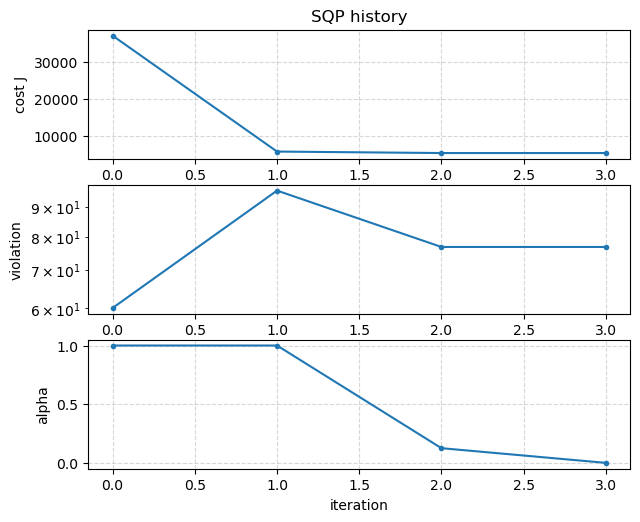

In [36]:
def plot_history(history, kkt=None):
    cleaned = []
    for i, h in enumerate(history):
        it_val = h.get('iter', i)
        try:
            it_int = int(it_val)
        except (TypeError, ValueError):
            continue  
        cleaned.append({
            'iter': it_int,
            'cost': float(h.get('cost', np.nan)),
            'violation': float(h.get('violation', np.nan)),
            'alpha': float(h.get('alpha', np.nan)),
        })

    if len(cleaned) == 0:
        print("No numeric iterations in history")
        return

    H = cleaned

    it  = np.array([h['iter'] for h in H], dtype=int)
    J   = np.array([h['cost'] for h in H], dtype=float)
    c   = np.array([h['violation'] for h in H], dtype=float)
    a   = np.array([h['alpha'] for h in H], dtype=float)
    kkt_arr = None if kkt is None else np.array(kkt, dtype=float)

    rows = 4 if kkt_arr is not None else 3
    plt.figure(figsize=(7, 1.9*rows))

    # Cost
    ax = plt.subplot(rows, 1, 1)
    ax.plot(it, J, '-o', lw=1.5, ms=3)
    ax.set_ylabel('cost J')
    ax.grid(True, ls='--', alpha=0.5)
    ax.set_title('SQP history')

    # Constraint violation
    ax = plt.subplot(rows, 1, 2)
    ax.plot(it, c, '-o', lw=1.5, ms=3)
    ax.set_ylabel('violation')
    ax.grid(True, ls='--', alpha=0.5)
    ax.set_yscale('log')

    # Line-search step
    ax = plt.subplot(rows, 1, 3)
    ax.plot(it, a, '-o', lw=1.5, ms=3)
    ax.set_ylabel('alpha')
    ax.set_xlabel('iteration')
    ax.grid(True, ls='--', alpha=0.5)

    # KKT norm
    if kkt_arr is not None:
        ax = plt.subplot(rows, 1, 4)
        ax.plot(it, kkt_arr, '-o', lw=1.5, ms=3)
        ax.set_ylabel('KKT')
        ax.set_xlabel('iteration')
        ax.set_yscale('log')
        ax.grid(True, ls='--', alpha=0.5)

def plot_U(U_opt, dt=None):
    T = U_opt.shape[0]
    t = np.arange(T) * (dt if dt is not None else 1.0)
    plt.figure(figsize=(6,3))
    plt.plot(t, U_opt[:,0], '-b', label='u1')
    plt.plot(t, U_opt[:,1], '-r', label='u2')
    plt.xlabel('time [s]' if dt is not None else 'step')
    plt.ylabel('thrust')
    plt.grid(True, ls='--', alpha=0.5)
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(history)

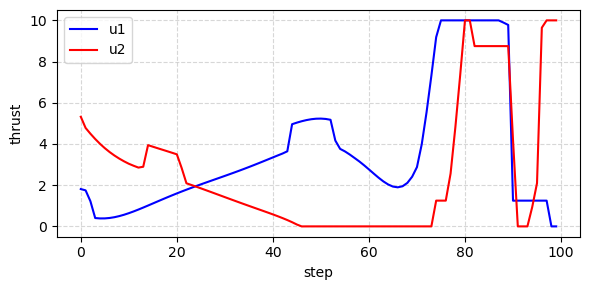

In [26]:
plot_U(u_opt)

## Part 2

In [43]:
class NMPC:
    def __init__(self, quadrotor, x0, X_ref_global, T_global, T,
                 P=P, Q=Q, R=R, u_min=0.0, u_max=10.0, rho=0.5, 
                 max_iter=128, min_iter=4, tol=1e-6):
        
        # Importing model
        self.quadrotor = quadrotor
        self.nx = quadrotor.DIM_STATE  
        self.nu = quadrotor.DIM_CONTROL

        # Reference Trajectory
        self.X_ref_global = X_ref_global
        self.T_global = T_global
        self.T = T
        
        self.z_warm = None

        # Weight Matrices // [px, vx, py, vy, theta, omega] // [u1, u2] // np.diag([1.0, 1.0])
        self.P = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) if P is None else P
        self.Q = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) if Q is None else Q
        self.R = np.eye(self.nu) if R is None else R
        self.u_min, self.u_max = u_min, u_max

        # Line search parameter
        self.rho = rho

        # General parameters
        self.max_iter = max_iter
        self.min_iter = min_iter
        self.tol = tol

        # initiliazing the solver
        self.solver = SQP_solver(quadrotor, T, x0,
                                 Q=Q, P=P, R=R, 
                                 min_iter= min_iter, max_iter= max_iter, tol = tol)

    def pack(self, X, U):
        return self.solver.pack(X, U)

    def slice_trajectory(self, t):
        X_ref = np.zeros((self.T + 1, self.nx))
        t_0 = int(t)
        t_1 = t_0 + self.T
        t_1_avail = min(t_1, self.T_global)
        if t_0 <= t_1_avail:
            n_main = (t_1_avail - t_0 + 1)
            X_ref[:n_main] = self.X_ref_global[t_0:(t_1_avail + 1)]
            if n_main < (self.T + 1):
                X_ref[n_main:] = self.X_ref_global[t_1_avail]
        else:
            X_ref[:] = self.X_ref_global[self.T_global]
        return X_ref


    def initial_guess(self,  x_0):
        X = np.zeros((self.T + 1, self.nx))
        U = np.zeros((self.T, self.nu))

        X[0] = x_0.copy()

        m = self.quadrotor.MASS
        g = self.quadrotor.GRAVITY_CONSTANT

        U[:] = np.array([m * g / 2.0, m * g / 2.0])
        
        del_t = self.quadrotor.DT
        for t in range(self.T):
            X[t+1] = X[t] + del_t * self.solver.next_state(X[t], U[t])
        return X, U

    def __call__(self, x, t):
        X_ref = self.slice_trajectory(t)
        self.solver.x_0 = x.copy()
        
        if self.z_warm is None:
            X_0, U_0 = self.initial_guess(x)
            z_0 = self.pack(X_0, U_0)
        else:
            z_0 = self.z_warm

        if t%10 == 0:
            print(f"time: {t * self.quadrotor.DT}")
        X_opt, U_opt, history = self.solver.solve_SQP(X_ref, z_0 = z_0)

        # Shifted warm start for next call
        X_w = np.zeros_like(X_opt)
        U_w = np.zeros_like(U_opt)

        X_w[:-1] = X_opt[1:]
        X_w[-1] = X_opt[-1]

        U_w[:-1] = U_opt[1:]
        U_w[-1] = U_opt[-1]

        self.z_warm = self.pack(X_w, U_w)  
        
        # ADD BASE THRUST + SATURATION HERE
        u = U_opt[0].copy()
        u = np.clip(u, self.u_min, self.u_max)
        return u

In [44]:
del_t = quadrotor.DT
duration = 10
T_total = int(duration/del_t)

def get_trajectory(waypoints, dt):
    t_wp = waypoints[:, 0]
    X_wp = waypoints[:, 1:]
    nx = X_wp.shape[1]
    t_final = float(t_wp[-1])
    T = int(np.round(t_final / dt))
    ts = np.linspace(0.0, t_final, T + 1)
    Xref = np.zeros((T + 1, nx))
    for j in range(nx):
        spl = CubicSpline(t_wp, X_wp[:, j], bc_type='natural')
        Xref[:, j] = spl(ts)
    return Xref

waypoints = np.array([
    # [t, px, vx, py, vy, theta, omega]
    [0.0,  0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    # [3.0,  0.0, 0.0, 1.2, 0.0,  -2*np.pi, 0.0],
    # [T_total,  0.0, 0.0, 1.2, 0.0,  -2*np.pi, 0.0],
    [duration,  0.0, 0.0, 1.5, 0.0,  2*np.pi, 0.0],
])

x_0 = waypoints[0, 1:]
X_ref = get_trajectory(waypoints, del_t)
Nhorizon = 200

P = np.diag([100.0, 50.0, 100.0, 50.0, 1000.0, 250.0])
Q = np.diag([500.0, 50.0, 500.0, 50.0, 2000.0, 250.0])
R = 1e-3 * np.eye(2)

controller = NMPC(quadrotor, x_0, X_ref, T_total, Nhorizon,  Q=Q, P=P, R=R, min_iter= 0, max_iter= 32, tol = 1e-4)
t, state, u = quadrotor.simulate(x_0, controller, T_total, disturbance=True)
quadrotor.animate_robot(state, u)


time: 0.0
time: 0.4
time: 0.8
time: 1.2
time: 1.6
time: 2.0
time: 2.4
time: 2.8000000000000003
time: 3.2
time: 3.6
time: 4.0
time: 4.4
time: 4.8
time: 5.2
time: 5.6000000000000005
time: 6.0
time: 6.4
time: 6.8
time: 7.2
time: 7.6000000000000005
time: 8.0
time: 8.4
time: 8.8
time: 9.200000000000001
time: 9.6


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABZAG1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3IGxvb2thaGVhZF90aHJlYWRz
PTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEaxliIQAN//+9vD+BTY7mNCX
Ec3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMAJgAGCANgAzAEdwBJhifrPwAL
wRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJujXVK9mpvpov1Dq5CrLp26+E
/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER1+dwaLseoQTUOIHe+AjMd/01
j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlDkHggnz8ibjDHy6sod15ejTD7
nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgrySjKMHT/BXnDAgmDXfO64jpi
yGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8dV/vzdPNgHyNMPd7Qeurp1Kv
ON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm3MWiO6d6NaNes2ZxjPgWoV3p
Wkje1mKUkGtlApOFiP89izn4l4W4+hf3LyzVN51uNpUvVYypDS+gpC1LnZTRKKLkhiARCz8vUNE2
jmd9LBuop4wtHxWyQ+hIDVe6n4Pcoo/9RyuTt19uWVECJXQ5P2rbxI5GlCWiJMavXMOUuYlJBrvh
IWmp7Grh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ2UCe1W6p2YBPju3XCRbv1SUW
h+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcAxLQ3PrLHc2GMPnZEJfxoC+wB
YhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7sA/1MVNHQEZn8PVx0E7zdACzS
SpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5TROC2Y81b4lVRo85K9ALdVT88
zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+/UwWvmDPTn9cTK5z3Vxl7LtL
Ebhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEuGIyXAZ8dExE3ggS3C04yJjAg
tHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkcyq1tCyReJ2zQBZtiL+Q3loxt
WdewSaQ+NnVN7fG8qziVfQ55Fst86EHRbfp6enX6l609SVLqc8hcxf/fCQwUA3xUgn9ALzX/KIqI
s204slWYN4Bk3i0PMdv4mAPQ3kYPhLZ2GJFrqmMsOmKKc+fGkIXiCsZIoKF5Reli6qIvktB/sjAA
AAMAAAkWyMDgiQ3CAAD25LJ0pCgACE8MQmths/crKZEaBrVS6iGbEqFkfZifmUrRbNJwvZYaNMH9
6RN3LRCPq/RXGzGX0hFIuE8ZirDiWjSH0bLUvnvt+isUUpHGKHPqTPHr8EujiKLJi/aGN1s3xaKD
nG1ivXAY3HQqHwUYmmVm1jes1fWyLPsZsTEraKWBmhjci9KrIb6unc0hgHKB1AFj2CiLpAv0SqQh
oZKtO2qErGRMMEtqNiFZwvI0HQqdq+uCGfPY994FpYaocIqGP5EzKd3H943oH5KDIn6fGKOrCbfI
Hnmp1WtUiNPD4Q34k6qR5sOzZ040/cxPUpkwFznkUjajGDUinFd+f/mMg15EisHvmhn6btYT6zQk
A0KddlcW7rsQqFrDWgZ/hDXrIkUGH19kSxUEPRPR+oIONV+QpOZyedSLwMFM+pJYxLuR2CXhN7XW
FONS/oCS7ZgnCzuM/YkLW/YaiQy49GW/8EAXMo9jWecsADC84AJVKD7gSSSAAAADAAADAMKj4z6P
Qvu3AxOKPomor/XTmSDN/7v5XtLbPXiDhIy3b/CfHMM2Cwcflq69jEMjhbYqt6PfEO9lQoJd+D6U
lLGbLKRD7qvNQ+jkPGpZlqkc1s84AAG6NSqrFXyldOJH+wdHNprKWWhdu75ZtyCCGWfz50D/507O
tXz/HTMyksNfGhiF4rcKT4pPt6o9jXfbiipa4fHqN4656pH5soI3XHsZknBRqPZXkc/vzbmGRpBk
tEAlRdh+xBwnK+Lpe7lJPEeinVKJ/LKEXB3d+9lNBzyDLtrw7N6TE1PG1XCuNWxvDwcwbODMAF8K
0yHBk19B/SkEpTpNH5OuVPNF/BNA6q4jEMTNGzXFI7D96xChhIFNdP109MS52nJAzyYZMhB96BQX
l83LGMGMGKglPvBIzWhg3L4gL9ulWE/J+5Wt4pPjLDwKlEn8UP2B4nM9QyxBwEEuuOvhRfI9wEo7
8yRCqB2BKf/x/W4MDXl3ETXH16x0vQJAtJi/Td4LuTQLc6jiRYRsHA2I1KTyaFwedOAUiF2wPMfS
yX2Op7KvFt+bRQYxm6VNb0clswBUX90kbn09CVTLEnGlOkR694t4q4y7CzKIC3UAb1Tq7BY55G7b
qs0nJlR2yxSsAINhgYupt3OhohpYkcchOUiPorpBB2rUPJIEO55MLmKzBYtmDToTMtu00aA6Rcgt
H5kgT9UgHaWRoSzD3rJ5trRzPNa8SdOvGCWSQ4dIvdVH5QwJpt8DnksXWVgnN3XZ7siSz4cVabD7
Ntw6cJneaP9FdPeDW5Ld2L0OLSKsNBjIk2owgYASWQ4wAa/+UdtZPaunRN8ffFMh6LXzg/qcAJqm
rF1gAAADAAAg03y/pSXN5DkocBh5+QfZfcGPwuRE62q0ZTGYTAIG3iU17l1xX4f6Za7PCTBx48ix
y7l0jRFH5gloDN3Tr0vUivwnuqD6D9FFIAWl0G9eKlZB6vR/+ZINl1McuXU1P9vSpH8xZqfOYrzv
Ez/+4yrpsRRFQ59sjIg8j

## Bonus (10 points)
Add a state constraint to perform the looping while maintaining a positive altitude. Use the origin as an initial state.

In [ ]:
def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
quadrotor.animate_robot(state, u)